### Module Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pickle

from sklearn.model_selection import cross_validate, cross_val_score

### Dataset Definition

In [2]:
df = pd.read_csv('stroke_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Stratification of the Dataset

In [3]:
X = df.drop('stroke', axis = 1)
y = df.stroke

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
print(Counter(y))
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 4733, 1: 248})
Counter({0: 3786, 1: 198})
Counter({0: 947, 1: 50})


In [6]:
print((248)/(248 + 4733))
print((198)/(198 + 3786))
print((50)/(50 + 947))

0.049789198956032926
0.04969879518072289
0.05015045135406219


### Separation of the Test Dataset

In [7]:
data_test = pd.concat([X_test, y_test], axis = 1)

In [8]:
data_test.to_csv('test.csv')

In [9]:
X_train.smoking_status.value_counts()

never smoked       1455
Unknown            1197
formerly smoked     712
smokes              620
Name: smoking_status, dtype: int64

### Null Imputation

In [10]:
def impute_smokers_age(X_train):
    min_age = 12

    X_train.loc[(X_train['age'] <= min_age) & (X_train['smoking_status'] == 'Unknown'), 'smoking_status'] = 'never smoked'
    X_train.loc[(X_train['smoking_status'] == 'Unknown'), 'smoking_status'] = np.nan

    # imputer = SimpleImputer(strategy = 'most_frequent')
    # X_train = pd.DataFrame(imputer.fit_transform(X_train))
    return X_train

In [11]:
X_train = impute_smokers_age(X_train)

In [12]:
X_train.iloc[:,9].value_counts()

never smoked       1868
formerly smoked     712
smokes              620
Name: smoking_status, dtype: int64

In [13]:
X_train.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status       784
dtype: int64

### Simple Preprocessing

In [14]:
cat = X_train.select_dtypes(include = ['object'])
cat_columns = list(cat)

num = X_train.select_dtypes(include = ['number'])
num_columns = list(num)

In [15]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('most_freq', SimpleImputer(strategy = 'most_frequent')), ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [16]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_columns), ('cat', categorical_transformer, cat_columns)], remainder = 'passthrough')

In [17]:
X_transformed = preprocessor.fit_transform(X_train)

In [18]:
X_transformed

array([[-0.8668014 , -0.32894656, -0.2388395 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.79493002, -0.32894656, -0.2388395 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.12204565, -0.32894656, -0.2388395 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.41490003, -0.32894656, -0.2388395 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.01713062, -0.32894656, -0.2388395 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.06132722,  3.04000744, -0.2388395 , ...,  0.        ,
         0.        ,  1.        ]])

### Model test

In [19]:
def prediction(model, data_to_predict):
    '''
    Esta función recibe el modelo que debe aplicarse y la matriz X (variables predictoras)
    Retorna la y que predice
    '''
    y_predicted = model.predict(data_to_predict)
    
    probability = model.predict_proba(data_to_predict)
    
    #tomamos como clase positiva (1)
    y_probs = probability[:, model.classes_.tolist().index(1)]
    
    return y_predicted, y_probs

In [20]:
def test(model, data_to_predict, y_predicted, y_true, y_probs):
    '''
    Esta función calcula las métricas del modelo y las imprime
    Toma como clase positiva (pos_label) a 'satisfied'  
    '''
    eval_metrics = ['accuracy', 'precision', 'recall', 'f1']
    model_scores = cross_validate(model, data_to_predict, y_true, cv=3, scoring = eval_metrics, return_train_score = True)
    
    acc = np.mean(model_scores['test_accuracy'])
    precision = np.mean(model_scores['test_precision'])
    recall = np.mean(model_scores['test_recall'])
    f1 = np.mean(model_scores['test_f1'])
    
    overfit_acc = (np.mean(model_scores['train_accuracy']) - np.mean(model_scores['test_accuracy'])) * 100
    overfit_pre = (np.mean(model_scores['train_precision']) - np.mean(model_scores['test_precision'])) * 100
    overfit_rec = (np.mean(model_scores['train_recall']) - np.mean(model_scores['test_recall'])) * 100
    overfit_f1 = (np.mean(model_scores['train_f1']) - np.mean(model_scores['test_f1'])) * 100
    
    conf_matrix = confusion_matrix(y_true, y_predicted)
   
    print('Model: {} || Accuracy: {} || Precision: {} || Recall: {} || F1: {}'.format(model, acc, precision, recall, f1))
    print()
    print('Model: {} || Overfitting Accuracy: {}, || Overfitting Precision: {}, || Overfitting Recall: {}, || Overfitting F1: {}'.format(model, overfit_acc, overfit_pre, overfit_rec, overfit_f1))
    print()
    print("Matriz de Confusión:")
    print(conf_matrix)
    print()
    print("Curva ROC-AUC:")
    plot_roc_curve(y_true, y_probs)

In [21]:
def plot_roc_curve(y_true, y_probs):
    '''
    Esta función muestra la curva ROC del modelo. Recibe como parámetros 
    la y verdadera y las probabilidades calculadas en la función prediction.
    '''
    fpr, tpr, _ = roc_curve(y_true, y_probs, pos_label = 1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'Curva ROC (Área (AUC) = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc = 'lower right')
    plt.show()

In [22]:
def train_predict_test(model, data_to_predict, y_true):
    '''
    Esta función agrupa todas las anteriores para hacer un sólo llamado
    '''
    print(f"Métricas de {model}:")

    model.fit(data_to_predict, y_true)

    y_predicted, y_probs = prediction(model, data_to_predict)

    test(model, data_to_predict, y_predicted, y_true, y_probs)

Métricas de RandomForestClassifier():
Model: RandomForestClassifier() || Accuracy: 0.9482931726907631 || Precision: 0.0 || Recall: 0.0 || F1: 0.0

Model: RandomForestClassifier() || Overfitting Accuracy: 5.1706827309236925, || Overfitting Precision: 100.0, || Overfitting Recall: 100.0, || Overfitting F1: 100.0

Matriz de Confusión:
[[3786    0]
 [   0  198]]

Curva ROC-AUC:


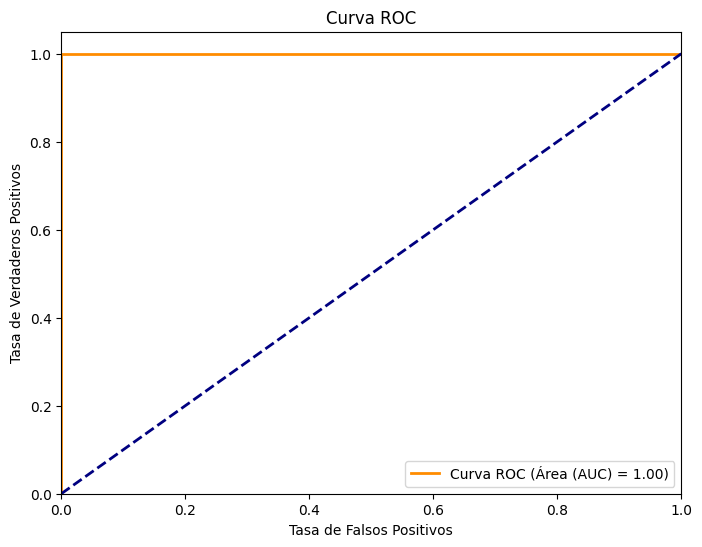

Métricas de LogisticRegression():
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packag

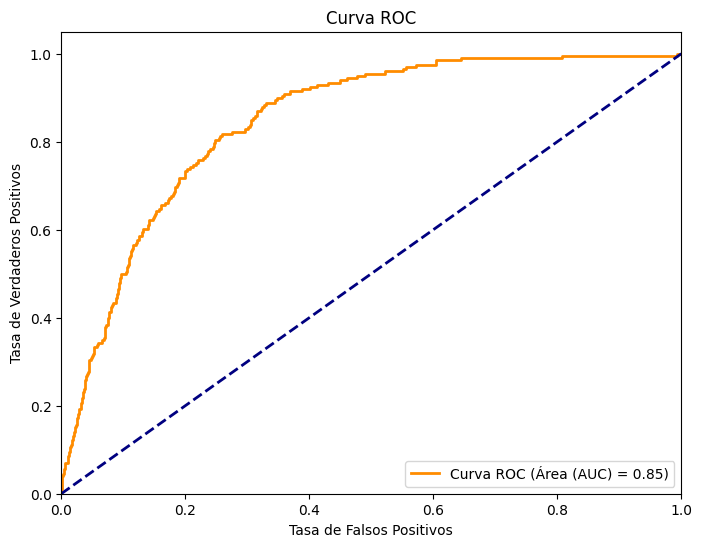

In [23]:
models = [RandomForestClassifier(), LogisticRegression()]

for model in models:
    train_predict_test(model, X_transformed, y_train)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af12788f-aecc-4989-a302-f8b336f386d1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>